## Transfer Learning on PyTorch

On this chapter we will learn about 2 scenarios on transfer learning

* Initialize the network with a set of weights trained from another session. (Instead of initializing the network with random values).
* Load some network, freeze it's weights up to a certain point and re-train the rest, normally on a smaller dataset.


References:
* http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()

### Define some Helper functions

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # Convert to numpy and transpose the dimensions
    inp = inp.numpy().transpose((1, 2, 0))
    # Recover from normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    # Show images
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def check_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return    

### Define data Augmentation

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Load data

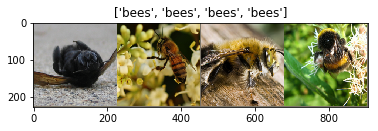

In [4]:
data_dir = 'hymenoptera_data'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable and put on GPU if available
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

### Learning rate Decay

In [6]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

### Get a pre-trained resnet and change the FC layer by a new one

In [7]:
# Download(if needed) a pre-trained (Imagenet) resnet 18
model_ft = models.resnet18(pretrained=True)

# Change FC layer (Classify between bee and Ant)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

# Put model on GPU if available
if use_gpu:
    model_ft = model_ft.cuda()

# Use cross entropy loss
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1443 Acc: 0.6967
val Loss: 0.0801 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.0922 Acc: 0.8156
val Loss: 0.0642 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.1818 Acc: 0.7664
val Loss: 0.1184 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.1063 Acc: 0.8238
val Loss: 0.0890 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.2060 Acc: 0.7090
val Loss: 0.0785 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.1316 Acc: 0.7992
val Loss: 0.1023 Acc: 0.8170

Epoch 6/24
----------
train Loss: 0.1075 Acc: 0.7992
val Loss: 0.0741 Acc: 0.9150

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0686 Acc: 0.8811
val Loss: 0.0771 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.0774 Acc: 0.8770
val Loss: 0.0672 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.0883 Acc: 0.8484
val Loss: 0.0595 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.0690 Acc: 0.8689
val Loss: 0.0707 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.0710 Acc: 

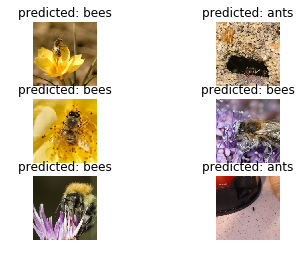

In [9]:
check_model(model_ft)

## ConvNet as fixed feature extractor (Freeze layers)

In [10]:
# Download(if needed) a pre-trained (Imagenet) resnet 18
model_conv = torchvision.models.resnet18(pretrained=True)

# Freeze all parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Add a new fc layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1468 Acc: 0.6762
val Loss: 0.0517 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.2316 Acc: 0.6557
val Loss: 0.0507 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.1021 Acc: 0.8197
val Loss: 0.0399 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.1723 Acc: 0.7295
val Loss: 0.0426 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.1104 Acc: 0.8033
val Loss: 0.0429 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.1066 Acc: 0.8279
val Loss: 0.0381 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.1132 Acc: 0.8197
val Loss: 0.0704 Acc: 0.8824

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0750 Acc: 0.8566
val Loss: 0.0380 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.0893 Acc: 0.8361
val Loss: 0.0375 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.0788 Acc: 0.8402
val Loss: 0.0475 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.0784 Acc: 0.8730
val Loss: 0.0427 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.0808 Acc: 

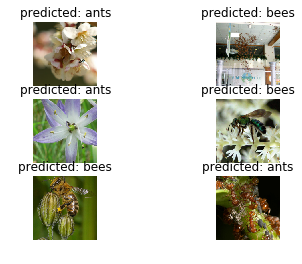

In [12]:
check_model(model_conv)

plt.ioff()
plt.show()